In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Рассмотрим функцию плотности нормального распределения $N(0,1)$ на отрезке $[-4, 4]$. Выберем множество узлов интерполяции так, чтобы сетка была равномерной.

In [2]:
def f_normal(x, mu, sq_sigma):
    return 1/np.sqrt(2*np.pi*sq_sigma) * np.exp(-(x-mu)**2/(2*sq_sigma))

In [3]:
n_xs = np.linspace(-4, 4, 1021)
n_ys = [f_normal(x, 0, 1) for x in n_xs]
xs = [x for x in n_xs if n_xs.tolist().index(x) % 85 == 0]
ys = [f_normal(x, 0, 1) for x in xs]

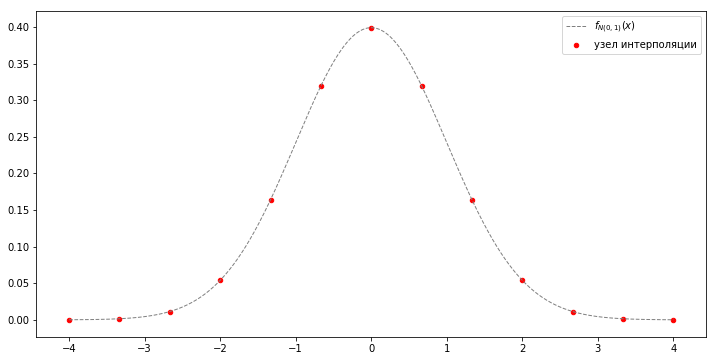

In [4]:
plt.figure(figsize=(12,6))
plt.plot(n_xs, n_ys, '--', color='gray', lw=1, label='$f_{N(0,1)}(x)$');
plt.scatter(xs, ys, color='r', s=20, label='узел интерполяции');
plt.legend();

Таким образом поставлена задача глобальный интерполяции таблично заданной функции на отрезке [-4, 4]. 

In [5]:
data = [xs, ys]
pd.DataFrame(data, index=['x', 'y'], columns=range(1, 14))

,1,2,3,4,5,6,7,8,9,10,11,12,13
x,-4.000000,-3.333333,-2.666667,-2.000000,-1.333333,-0.666667,0.000000,0.666667,1.333333,2.000000,2.666667,3.333333,4.000000
y,0.000134,0.001542,0.011396,0.053991,0.164010,0.319448,0.398942,0.319448,0.164010,0.053991,0.011396,0.001542,0.000134


### Алгебраическая интерполяция

Коэффициенты разложения находим аналогично методу наименьних квадратов сведением к канонической системе. Согласно теореме существует один и только один многочлен $P_n(x) = P_n(x, f, x_0, x_1, ..., x_n)$ степени не выше $n$, принимающий в узлах $x_k$ заданные значения $f(x_k)$. В такой интерпретации метод наименьших квадратов позволяет найти искомый интерполяционный многочлен. 

In [6]:
def get_A(xs, N):
    return np.array([[x**i for i in range(N)] for x in xs])

def inter_coefs(A, f):
    hat_A = np.dot(A.T, A)
    hat_f = np.dot(f, A)
    coefs = np.linalg.solve(hat_A, hat_f)
    return coefs

def poly_inter(xs, coefs, N):
    return [sum([coefs[i]*x**i  for i in range(N)]) for x in xs]

In [7]:
N = 13
A = get_A(xs, N)
coefs = inter_coefs(A, ys)
inter_vals = poly_inter(n_xs, coefs, N)

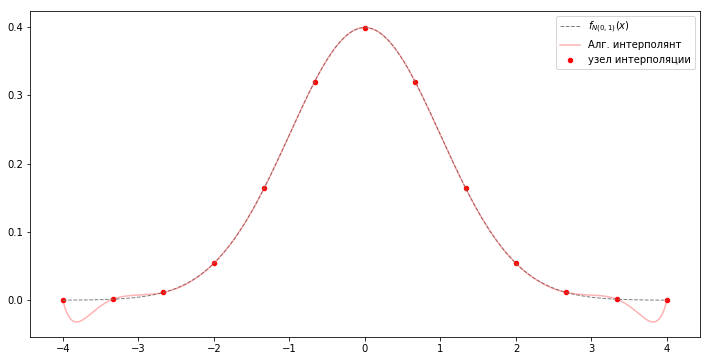

In [8]:
plt.figure(figsize=(12,6))
plt.plot(n_xs, n_ys, '--', color='gray', lw=1, label='$f_{N(0,1)}(x)$');
plt.scatter(xs, ys, color='r', s=20, label='узел интерполяции');
plt.plot(n_xs, inter_vals, color='r', alpha=.3, label='Алг. интерполянт');
plt.legend();

Очевидно, что в данном методе присутсвуют аномалии вблизи крайних узлов. 

Оценим качество интерполяции путем вычисления _mae_ в точках более мелкой сетки из 1020 элементов. 

In [9]:
def mae(ys1, ys2):
    return np.mean([abs(ys1[i]-ys2[i]) for i in range(len(ys1))])

In [10]:
err = mae(inter_vals, n_ys)
print('MAE = %0.5f' %err)
print('Точность: %0.2f%%' %(100*err))

MAE = 0.00345
Точность: 0.34%


Вполне очевидно, что существенный вклад в ошибку вносят аномалии вблизи краев отрезка.

### Метод обратных взвешенных расстояний (IDW)

Метод обратных взвешенных расстояний (IDW) однозначно предполагает, что объекты, которые находятся поблизости, более подобны друг другу, чем объекты, удаленные друг от друга. Данное предположение реализуется с помощью подсчета взвешенного среднего по известным точкам. 

Интерполяционная функция Шепарда метода IDW задается как:

$u(x) = \begin{cases}
 \frac{\sum_{i = 1}^{n}{ w_i(x) y_i } }{ \sum_{i = 1}^{n}{ w_i(x) } }, & \text{если } d(x,x_i) \neq 0 \,
 \forall i, \\
 y_i, & \text{если } d(x,x_i) = 0 \text{ для некоторого } i,
\end{cases} $, где $w_i(x) =  \frac{1}{d(x,x_i)^p}$ и $d(\cdot, \cdot)$ - евклидово расстояние, $p$ - параметр

In [11]:
def u(x0, p, xs, ys):
    if x0 in xs:
        return ys[xs.index(x0)]
    else:
        numer = np.sum([ys[i]/(x0-xs[i])**p for i in range(len(ys))])
        denom = np.sum([1/(x0-xs[i])**p for i in range(len(ys))])
        return numer/denom

In [12]:
p=2
idw_vals = [u(x, p, xs, ys) for x in n_xs]

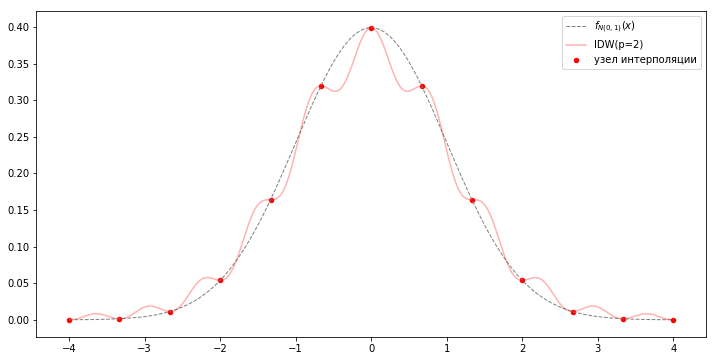

In [13]:
plt.figure(figsize=(12,6))
plt.plot(n_xs, n_ys, '--', color='gray', lw=1, label='$f_{N(0,1)}(x)$');
plt.scatter(xs, ys, color='r', s=20, label='узел интерполяции');
plt.plot(n_xs, idw_vals, color='r', alpha=.3, label=f'IDW(p={p})');
plt.legend();

Легко видеть, что данный метод не применим к поставленной задаче. Прежде всего это связано с требовательностью метода взвешенного среднего к высокой плотности сетки, в нашем же случае сетка довольно разрежена, что негативно сказывается на точности. 

In [14]:
err = mae(idw_vals, n_ys)
print('MAE = %0.5f' %err)
print('Точность: %0.2f%%' %(100*err))

MAE = 0.01301
Точность: 1.30%


### Кусочно-многочленная интерполяция. Сплайны

Рассмотрен и реализован __естественный кубический сплайн__ _(в некотрых источниках он назывался наиболее широко распространнем на практике в случае необходимости гладкой интерполяции, поэтому и был выбран к реализации)_

Кубический сплайн состоит из кусков вида $P_i(x) = a_i + b_i (x-x_i) + c_i(x-x_i)^2 + d_i (x-x_i)^3$. 

В поставленой задачи задано $k+1$ точек $(x_0, y_0), \dots (x_k, y_k)$, мы ищем $k$ полиномов $P_i(x)$, которые удовлетворяеют для $1 \le i \le k-1$ условиям:

* $P_0(x_0) = y_0$ и $P_{i-1}(x_i) = y_i = P_i(x_i)$
* $P'_{i-1}(x_i) = P'_i(x_i)$
* $P''_{i-1}(x_i) = P''_i(x_i)$
* $P''_0(x_0) = P''_{k-1}(x_k)$

Каждый такой полином $P_i$ задается пятеркой $(a, b, c, d, x)$, где $a$, $b$, $c$, $d$ - коэффициенты многочлена, а $x$ соответствует области определения полинома $[x_i, x_{i+1}]$.

Данный сплайн относительно прост в реализации и для него есть стандартный алгоритм вычисления, который реализован ниже. 

In [15]:
def natural_cubic_spline(xs, ys):
    k = len(xs) - 1
    a = ys[:]
    b, d, mu = np.zeros(k), np.zeros(k), np.zeros(k)
    h = [xs[i+1]-xs[i] for i in range(k)]
    alpha = [3/h[i]*(a[i+1]-a[i]) - 3/h[i-1]*(a[i]-a[i-1]) for i in range(k-1)]
    c, l, z = np.zeros(k+1), np.zeros(k+1), np.zeros(k+1)
    l[0] = 1
    
    for i in range(1, k-1):
        l[i] = 2*(xs[i+1]-xs[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i]-h[i-1]*z[i-1]) / l[i]
    l[k] = 1

    for j in range(k-1, -1, -1):
        c[j] = z[j]-mu[j]*c[j+1]
        b[j] = (a[j+1]-a[j])/h[j] - h[j]*(c[j+1]+2*c[j])/3
        d[j] = (c[j+1]-c[j])/(3*h[j])
    
    params = [[a[i], b[i], c[i], d[i], xs[i]] for i in range(k)]
    return params

In [16]:
def P(x0, params):
    i = np.max([i for i in range(len(params)) if params[i][4]<=x0])
    a, b, c, d, x = params[i]
    return a + b*(x0-x) + c*(x0-x)**2 + d*(x0-x)**3

In [17]:
params = natural_cubic_spline(xs, ys)
spline_vals = [P(x, params) for x in n_xs]

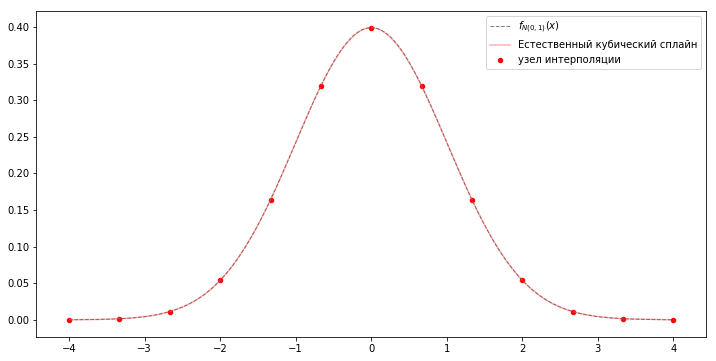

In [18]:
plt.figure(figsize=(12,6))
plt.plot(n_xs, n_ys, '--', color='gray', lw=1, label='$f_{N(0,1)}(x)$');
plt.scatter(xs, ys, color='r', s=20, label='узел интерполяции');
plt.plot(n_xs, spline_vals, color='r', alpha=.3, label='Естественный кубический сплайн');
plt.legend();

In [19]:
err = mae(spline_vals, n_ys)
print('MAE = %0.5f' %err)
print('Точность: %0.3f%%' %(100*err))

MAE = 0.00021
Точность: 0.021%


Подтвердилась изначальная гипотеза о лучшей точности интерполяции по сравнению с другими моделями.